This notebook contains the solution for the Spotahome test

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats.distributions import norm

In [2]:
# Load table from database to pandas
con = sqlite3.connect('Data scientist exercise.db')
df = pd.read_sql('SELECT * FROM access_log', con)

df.datetime = pd.to_datetime(df.datetime)
df.user_id = df.user_id.astype(int)

# EDA 
After exploring the variables everything looks normal but some insight can be highlighted.

### Events and time dependency

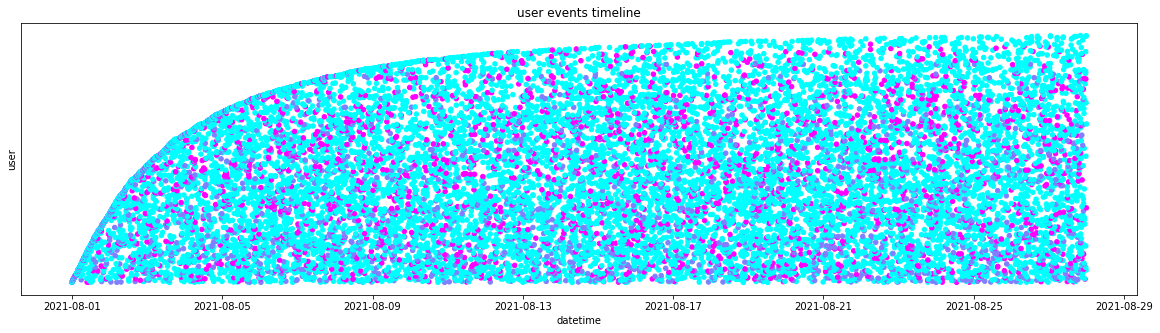

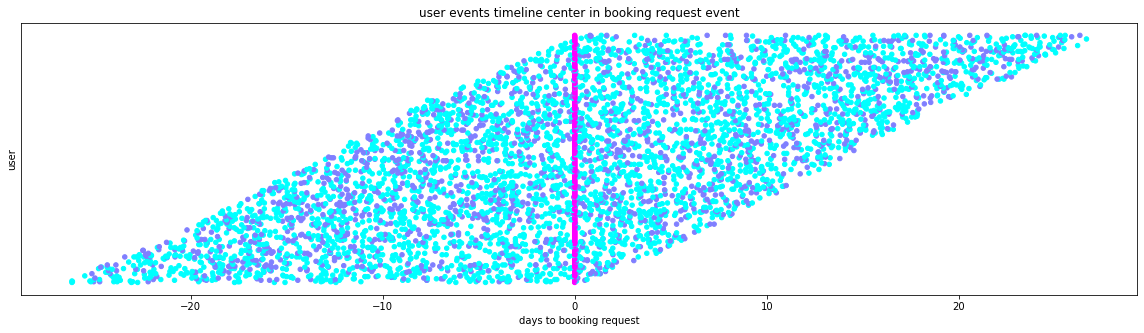

In [12]:
# PLOT USER EVENTS TIMELINE
user_with_revenue = df.loc[df.revenue > 0, 'user_id'].unique()
event_dict = {'property_view': 0,
              'property_favorite_added': 0.5,
              'booking_request': 1}

fig, ax = plt.subplots(figsize=(20, 5))

for i, user in enumerate(df.user_id.unique()[:]):

    df_plot = df[df.user_id == user].copy()
    df_plot['event_col'] = df_plot.event_type.replace(event_dict)
    df_plot['index_col'] = i

    df_plot.plot(x='datetime', y='index_col', kind='scatter',
                 c='event_col', cmap='cool', colorbar=False, ax=ax)

ax.set_ylabel('user')
ax.set_yticks([])
plt.title('user events timeline')
plt.show()

# PLOT USER EVENTS TIMELINE ONLY FOR BOOKING REQUESTS
df_revenue = df[df.user_id.isin(user_with_revenue)]
df_revenue_date = df_revenue.loc[df_revenue['revenue'].notna(),
                                 ['user_id', 'datetime']]
df_revenue_merge = pd.merge(df_revenue, df_revenue_date, on='user_id')
df_revenue_merge['timedelta'] = \
    df_revenue_merge.datetime_y - df_revenue_merge.datetime_x

fig, ax = plt.subplots(figsize=(20, 5))
for i, user in enumerate(user_with_revenue):

    df_plot = df_revenue_merge[df_revenue_merge.user_id == user].copy()
    df_plot['event_col'] = df_plot.event_type.replace(event_dict)
    df_plot['index_col'] = i
    df_plot['timedelta'] = df_plot['timedelta']/pd.Timedelta(days=1)
    df_plot.plot(x='timedelta', y='index_col', kind='scatter',
                 c='event_col', cmap='cool', colorbar=False, ax=ax)
ax.set_ylabel('user')
ax.set_yticks([])
ax.set_xlabel('days to booking request')
plt.title('user events timeline center in booking request event')
plt.show()

Data seems synthetic as there is no obvious correlation between the events and time.

### Booking request distribution

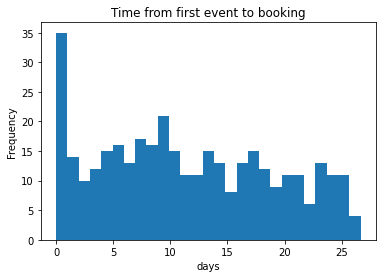

In [4]:
df_booking_users = df[df.user_id.isin(user_with_revenue)]
first_event = \
    df_booking_users.groupby('user_id')[['datetime']].min().reset_index()
revenue_time = df_booking_users.loc[df_booking_users.revenue.notna(),
                                    ['user_id', 'datetime']]

booking_window = pd.merge(revenue_time, first_event, on='user_id')
booking_window.columns = \
    ['user_id', 'booking_datetime', 'first_event_datetime']

time_to_booking = \
    booking_window.booking_datetime - booking_window.first_event_datetime

(time_to_booking/pd.Timedelta(days=1)).plot(
    kind='hist', bins=27, title='Time from first event to booking')
plt.xlabel('days')
plt.show()


The main consequence for the exercise is that booking_request are homogeneously distributed in the users lifetime.

That means it can take up to 27 days to book for a particular user.
Thus, user data for user with less than 27 days of data are not reliables for this analysis if this were not a toy exercise.

# Removing bad data

### User assigned to both variants 

After inspecting visually and statistically some of the user assigned to both variants and comparing with the properly assigned 
I cannot see anything special.

They have similar distributions on any feature.

It is only the 5% of data so **better ignore this not reliable rows**.

In [5]:
displayed_user_ids = 1
user_variants_count = df.groupby('user_id')['variant'].unique().apply(len)
both_variants_user_ids = user_variants_count[user_variants_count > 1].index
for user_id in both_variants_user_ids[:displayed_user_ids]:
    display(df[df.user_id == user_id].sort_values('datetime'))

,datetime,user_id,variant,city,event_type,revenue
390,2021-08-01 15:55:00,103751531,A,rome,property_view,NaN
2823,2021-08-05 16:52:54,103751531,A,rome,property_view,NaN
3012,2021-08-05 23:33:06,103751531,B,rome,property_view,NaN
3293,2021-08-06 09:56:24,103751531,A,rome,property_view,NaN
3713,2021-08-07 01:28:39,103751531,B,rome,property_view,NaN
4610,2021-08-08 11:02:46,103751531,B,rome,property_view,NaN
5548,2021-08-09 23:21:15,103751531,A,rome,property_view,NaN
6930,2021-08-12 06:30:38,103751531,B,rome,property_view,NaN
7527,2021-08-13 05:54:27,103751531,A,rome,property_view,NaN
8868,2021-08-15 12:09:11,103751531,B,rome,property_view,NaN


### Users with two request

Only one user preform more than one user request.
It also have mixed variant values so is ignored anyway

In [6]:
user_sales = df.groupby('user_id')['revenue'].count()
user_with_more_than_one_sale = user_sales[user_sales > 1].index
df[df.user_id.isin(user_with_more_than_one_sale)].sort_values('datetime')

,datetime,user_id,variant,city,event_type,revenue
305,2021-08-01 12:32:48,859812222,B,rome,property_favorite_added,NaN
1170,2021-08-02 23:48:49,859812222,A,rome,property_favorite_added,NaN
2516,2021-08-05 05:37:54,859812222,A,rome,property_view,NaN
3119,2021-08-06 03:55:29,859812222,A,rome,property_favorite_added,NaN
3465,2021-08-06 16:39:18,859812222,B,rome,property_favorite_added,NaN
3569,2021-08-06 20:13:22,859812222,A,rome,property_favorite_added,NaN
3664,2021-08-06 23:51:16,859812222,B,rome,property_view,NaN
3869,2021-08-07 07:49:11,859812222,A,rome,booking_request,229.319360
3873,2021-08-07 08:01:35,859812222,A,rome,property_favorite_added,NaN
4187,2021-08-07 19:37:29,859812222,B,rome,booking_request,338.171321


### zero revenue

There are few samples with zero revenue.

There is nothing special on this users data.

Probably there is an explanation for this events so I would ask the service developers before excluding this rows for the analysis in a real situation.

As long as I cannot do this, I will exclude the user related with this booking requests.

They represent only the 2% anyway.

In [8]:
displayed_user_ids = 1
zero_revenue_users = df.loc[df.revenue <= 0, 'user_id'].unique()
for user in zero_revenue_users[:displayed_user_ids]:
    display(df[df.user_id == user].sort_values('datetime'))

,datetime,user_id,variant,city,event_type,revenue
635,2021-08-02 02:28:12,928239809,A,rome,booking_request,0.0
3939,2021-08-07 10:32:54,928239809,A,rome,property_favorite_added,NaN
4856,2021-08-08 20:01:13,928239809,A,rome,property_view,NaN
5249,2021-08-09 12:08:08,928239809,A,rome,property_view,NaN
5798,2021-08-10 08:53:53,928239809,A,rome,property_view,NaN
5996,2021-08-10 16:46:00,928239809,A,rome,property_favorite_added,NaN
7127,2021-08-12 14:49:21,928239809,A,rome,property_view,NaN
8707,2021-08-15 05:20:55,928239809,A,rome,property_favorite_added,NaN
9621,2021-08-16 16:00:03,928239809,A,rome,property_favorite_added,NaN
10948,2021-08-18 21:59:27,928239809,A,rome,property_view,NaN


## Remove all the data mention before

In [9]:
both_variants_user_ids = user_variants_count[user_variants_count > 1].index

user_sales = df.groupby('user_id')['revenue'].count()
user_with_more_than_one_sale = user_sales[user_sales > 1].index

zero_revenue_users = df.loc[df.revenue <= 0, 'user_id'].unique()

users_to_exclude = set()
users_to_exclude = users_to_exclude.union(both_variants_user_ids)
users_to_exclude = users_to_exclude.union(user_with_more_than_one_sale)
users_to_exclude = users_to_exclude.union(zero_revenue_users)

df = df[~df.user_id.isin(users_to_exclude)]

# Questions to answer

## Conversion rate

What is the uplift or down-lift in the treatment group, if there’s any?

Is it statistically significant at 95% or 99% level? 

Indicate the kind of test performed and p-value.

### Answer
First lets visualize the data

,all cities
variant,
A,48.449901
B,62.446052


city,london,madrid,rome
variant,,,
A,42.140444,48.079464,49.650687
B,75.067195,55.136330,70.029195


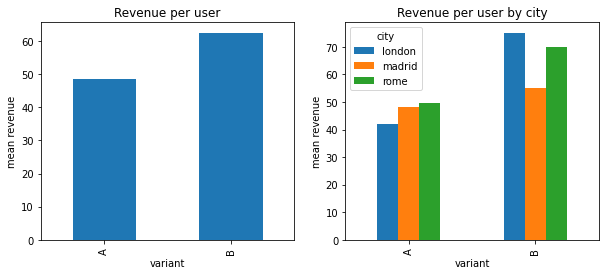

In [14]:
rpu = df.groupby(['variant'])[['revenue', 'user_id']].apply(
    lambda x: x['revenue'].sum()/x['user_id'].nunique())
display(pd.DataFrame(rpu, columns=['all cities']))

rpu = df.groupby(['variant', 'city'])[['revenue', 'user_id']].apply(
    lambda x: x['revenue'].sum()/x['user_id'].nunique())
rpu_pivot = rpu.unstack()
display(rpu_pivot)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

df.groupby(['variant'])[['revenue', 'user_id']].apply(
    lambda x: x['revenue'].sum()/x['user_id'].nunique()).plot(
    kind='bar', title='Revenue per user', ax=ax[0])
ax[0].set_ylabel('mean revenue')

rpu_pivot.plot(kind='bar', title='Revenue per user by city', ax=ax[1])
ax[1].set_ylabel('mean revenue')

plt.show()

It is clear that cities cannot be treated altogether

Conversion rate distributions independence for group A and B is evaluated with the χ² of independence of variables.

In [13]:
survivors = df.groupby(['variant'])[['user_id',
                                     'revenue']].nunique().reset_index()
survivors.columns = ['variant', 'unique_users', 'booking']
survivors['not_booking'] = survivors.unique_users-survivors.booking
survivors = survivors.drop(columns='unique_users')
survivors = survivors.set_index('variant')

chi2, p_value, dof, expected = stats.chi2_contingency(survivors)
display(survivors)
print(f'p_value = {p_value:.3f}')

,booking,not_booking
variant,,
A,196,610
B,144,668


p_value = 0.001


Groups are statistically independent with a high level of significance

Now, the process is repeated considering each city independently

In [17]:
survivors_by_city = df.groupby(['city', 'variant'])[
    ['user_id', 'revenue']].nunique()

for city in df.city.unique():
    survivors = survivors_by_city.loc[city].reset_index()
    survivors.columns = ['variant', 'unique_users', 'booking']
    survivors['not_booking'] = survivors.unique_users - survivors.booking
    survivors = survivors.drop(columns='unique_users')
    survivors = survivors.set_index('variant')

    chi2, p_value, dof, expected = stats.chi2_contingency(survivors)
    display(survivors)
    print(f'{city} p_value = {p_value:.3f}\n\n')

,booking,not_booking
variant,,
A,86,259
B,68,273


rome p_value = 0.141




,booking,not_booking
variant,,
A,101,319
B,67,361


madrid p_value = 0.003




,booking,not_booking
variant,,
A,9,32
B,9,34


london p_value = 1.000




We can only affirm that the independence significance is high for Madrid

Probably the experiment do not affect significantly to London and Rome conversion rate

## Revenue per user

What is the uplift or down-lift in the treatment group, if there’s any? Is it

statistically significant at 95% or 99% level? 

Indicate the kind of test performed and p-value.

Remember we mean revenue per “website visitor”, not just per “user that converted”.

### Answer
First lets visualize the data


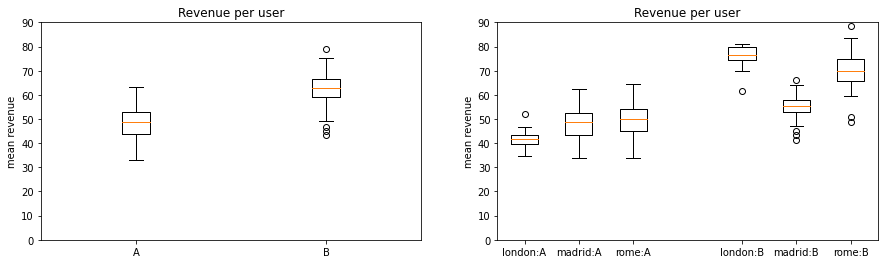

In [18]:
cities = ['london', 'madrid', 'rome']

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

boxplot_list = []
labels_list = []
for variant in ['A', 'B']:
    f = (df.variant == variant)
    unique_users = df.loc[f, 'user_id'].nunique()
    bookings = df.loc[f, 'revenue'].notna().sum()
    revenue = df.loc[f, 'revenue'].dropna()
    boxplot_list.append(revenue / unique_users * bookings)
    labels_list.append(f'{variant}')

ax[0].boxplot(boxplot_list,
              labels=labels_list)
ax[0].set_ylim(0, 90)
ax[0].set_ylabel('mean revenue')
ax[0].set_title('Revenue per user')

boxplot_list = []
labels_list = []
for variant in ['A', 'B']:
    for city in ['london', 'madrid', 'rome']:
        f = (df.city == city) & (df.variant == variant)
        unique_users = df.loc[f, 'user_id'].nunique()
        bookings = df.loc[f, 'revenue'].notna().sum()
        revenue = df.loc[f, 'revenue'].dropna()
        boxplot_list.append(revenue / unique_users * bookings)
        labels_list.append(f'{city}:{variant}')

ax[1].boxplot(boxplot_list,
              positions=[1, 2, 3, 5, 6, 7],
              labels=labels_list)
ax[1].set_ylim(0, 90)
ax[1].set_ylabel('mean revenue')
ax[1].set_title('Revenue per user')

plt.show()

It is clear that distributions are not similar even if they do not split by city.

Still, lets perform the two-sample Kolmogorov-Smirnov test for goodness of fit to prove it.

In [19]:
ks_test = ks_2samp(
    df.loc[df.variant == 'A', 'revenue'].dropna(),
    df.loc[df.variant == 'B', 'revenue'].dropna())
print(f'all cities p-value = {ks_test.pvalue:.1e}')
for i, city in enumerate(cities):
    ks_test = ks_2samp(boxplot_list[i], boxplot_list[i+3])
    print(f'{city} p-value = {ks_test.pvalue:.1e}')

all cities p-value = 6.4e-95
london p-value = 4.1e-05
madrid p-value = 7.3e-12
rome p-value = 1.8e-35


## Question
What would be your recommendation to stakeholders regarding rolling out or rolling back the experiment?

### Answer
**The price increment must be fit by city not globally**

## Increase ratio
The stakeholder forgot what was the % increase in fees applied in the treatment group, so let’s try to find out:

* Create a plot that shows a kernel density estimate of the revenue value for the booking requests, creating one different line per variant.
What can be learned from this plot?
* Can you determine the “average” revenue per booking request in each variant, with a confidence interval of 95%? (e.g. “352.25 euros +/- 22.3 euros” , or “[329.95, 375.55] euros”).
Choose an appropriate distribution as assumption.
* Finally, determine what was the percentage increase of the fees in treatment group. It is a reliable determination?

### Answer

A median distribution value = 199±48
B median distribution value = 352±63


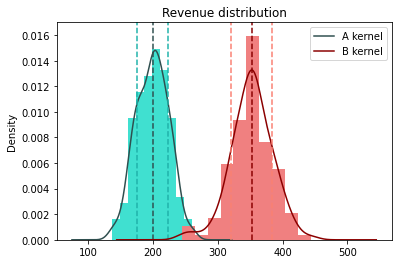

In [21]:
mean = {}
var = {}

for variant in ['A', 'B']:
    mean[variant], var[variant] = norm.fit(
        df.loc[df.variant == variant, 'revenue'].dropna())

    interval = norm.interval(alpha=0.95, loc=mean[variant], scale=var[variant])
    print(f'{variant} median distribution value = '
          f'{mean[variant]:.0f}±{interval[1]-mean[variant]:.0f}')

df.loc[df.variant == 'A', 'revenue'].hist(density=True, color='turquoise')
df.loc[df.variant == 'A', 'revenue'].plot(kind='density',
                                          color='darkslategray',
                                          label='A kernel')
plt.vlines(mean['A'], 0, 0.017, linestyle='--', color='darkslategray')
plt.vlines(mean['A']+var['A'], 0, 0.017, linestyle='--', color='lightseagreen')
plt.vlines(mean['A']-var['A'], 0, 0.017, linestyle='--', color='lightseagreen')

df.loc[df.variant == 'B', 'revenue'].hist(density=True, color='lightcoral')
df.loc[df.variant == 'B', 'revenue'].plot(
    kind='density', color='darkred', label='B kernel')
plt.vlines(mean['B'], 0, 0.017, linestyle='--', color='darkred')
plt.vlines(mean['B']+var['B'], 0, 0.017, linestyle='--', color='salmon')
plt.vlines(mean['B']-var['B'], 0, 0.017, linestyle='--', color='salmon')

plt.ylim(0, 0.017)
plt.title('Revenue distribution')
plt.legend()
plt.show()

Both distributions fit to a gaussian.

Taking advantage of this is possible to estimate the average revenue per booking with a 95% confidence interval:
* A median distribution value = 199±48
* B median distribution value = 352±63

With this information is possible to calculate te percentage increase as

$increase = m_B/m_a-1$

Lets calculate it with the error.

In [22]:
increase = mean['B']/mean['A']-1
error = np.abs((var['B']*mean['A']-mean['B']*var['A'])/(mean['A']**2))
print(f" The increment ratio is {increase:.1f}±{error:.1f}.")

 The increment ratio is 0.8±0.1.


The increment ratio is 0.8±0.1.
There is only a less than a 10% error.